In [1]:
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import random
import math

In [2]:
!pip install emcee
import emcee

!pip install corner
import corner

In [1]:
# p = [b,A,t0,alpha]  parameters vector

def model(p,x):  #model for the burst
    array = np.full_like(x,1)
    array[x<p[2]] = p[0]
    array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))
    return array

def log_likelihood(p,x,y,yerr):  #likelihood = prod(exp(-(y-model**2)/sigma**2)/(2*pi*sigma**2))
    return -0.5*np.sum((y-model(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

def prior(p):
    if p[3]<0:
        return 0
    prior_b = stats.uniform.pdf(p[0],loc=0,scale=50) #uniform distribution [0,50]
    prior_A = stats.uniform.pdf(p[1],loc=0,scale=50) #uniform distribution [0,50]
    prior_t0 = stats.uniform.pdf(p[2],loc=0,scale=100) #uniform distribution [0,100]
    #ln(alpha) uniform distribution [-5,5] --> p(alpha) = p(ln_alpha)/(alpha)
    prior_alpha = stats.uniform.pdf(np.log(p[3]),loc=-5,scale=10)/(p[3])
    if prior_b*prior_A*prior_t0*prior_alpha==0:
        return 0
    else:
        return prior_b*prior_A*prior_t0*prior_alpha

def log_posterior(p,x,y,yerr): #posterior = Likelihood x Prior
    lp = np.log(prior(p))
    ll = log_likelihood(p,x,y,yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf
    else:
        return ll+lp

In [4]:
data = np.load('transient.npy')

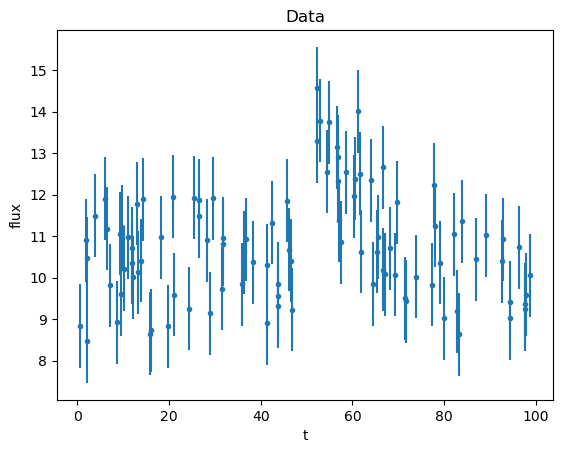

In [5]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('Data')
plt.show()

In [39]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 80000 # number of steps

starting_guesses = np.array([10,50,5,0.12])+1e-3*np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[data[:,0],data[:,1],data[:,2]])
sampler.run_mcmc(starting_guesses, nsteps)  #iterate nsteps times

C:\Users\giuli\AppData\Local\Temp\ipykernel_22328\2132717221.py:26: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))
C:\Users\giuli\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\giuli\AppData\Local\Temp\ipykernel_22328\2132717221.py:10: RuntimeWarning: overflow encountered in square
  return -0.5*np.sum((y-model(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))
C:\Users\giuli\AppData\Local\Temp\ipykernel_22328\2132717221.py:6: RuntimeWarning: overflow encountered in exp
  array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))
C:\Users\giuli\AppData\Local\Temp\ipykernel_22328\2132717221.py:6: RuntimeWarning: overflow encountered in multiply
  array[x>=p[2]] = p[0]+p[1]*np.exp(-p[3]*(x[x>=p[2]]-p[2]))


State([[10.22632953  5.17730975 49.4912316   0.10855357]
 [10.4999913   7.08810936 47.02952801  0.1481126 ]
 [10.20512641  4.88324368 51.1726135   0.12317659]
 [10.37888731  5.87864166 49.25867304  0.13273043]
 [10.28190712  5.57801735 49.64092063  0.11998744]
 [10.43115074  4.26859571 50.57781169  0.11973482]
 [10.24418923  5.79339819 47.83124873  0.12665025]
 [10.38232261  4.95806011 50.00793022  0.1338343 ]
 [10.1309627   2.98928998 52.11933857  0.07294622]
 [10.15396603  9.95162028 47.25620472  0.1650478 ]], log_prob=[-155.65803266 -157.97908199 -156.23459743 -156.07227366 -155.83399679
 -156.35684061 -157.09728108 -156.05285302 -158.19317536 -158.93305291], blobs=None, random_state=('MT19937', array([3889080929,   15244808,  722972799, 4011054838, 1128878465,
       3739148167, 3602208288, 1276583236, 3550262637,  424984059,
       3119142169,  933707192, 3327994948, 3934003476, 2585532577,
         91785144,   96056338, 1631263949, 3224267768, 1636977725,
        448890429, 35828

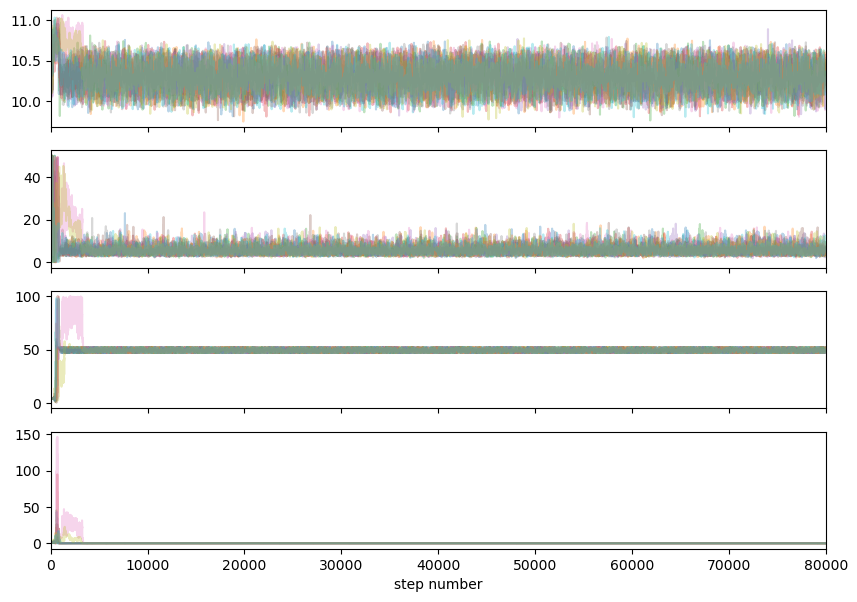

In [40]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
sampler_plot = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_plot[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(sampler_plot))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [41]:
autocorr = sampler.get_autocorr_time() #to get the autocorrelation time
autocorr

array([223.86562724, 650.42124758, 489.81942962, 699.19190139])

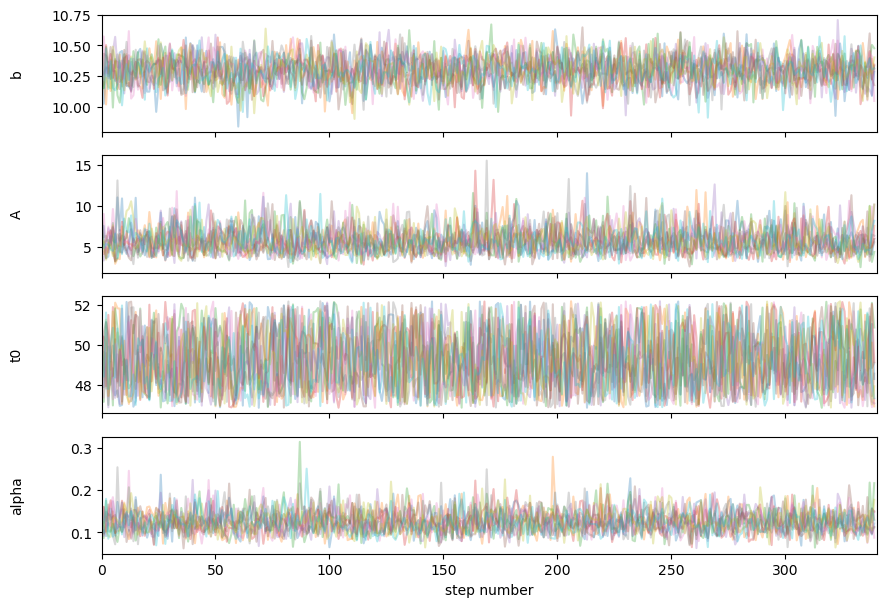

In [52]:
burn = 4000  # "burn-in" period
thin = int(np.min(autocorr))

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
plot_sampler = sampler.get_chain(discard=burn, thin=thin)
labels = ['b','A','t0','alpha']
for i in range(ndim):
    ax = axes[i]
    ax.plot(plot_sampler[:,:,i], alpha=0.3)
    ax.set_xlim(0, len(plot_sampler))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [53]:
medians = []
for i in range(ndim):
    medians.append(np.median(sampler_plot[:,:,i]))

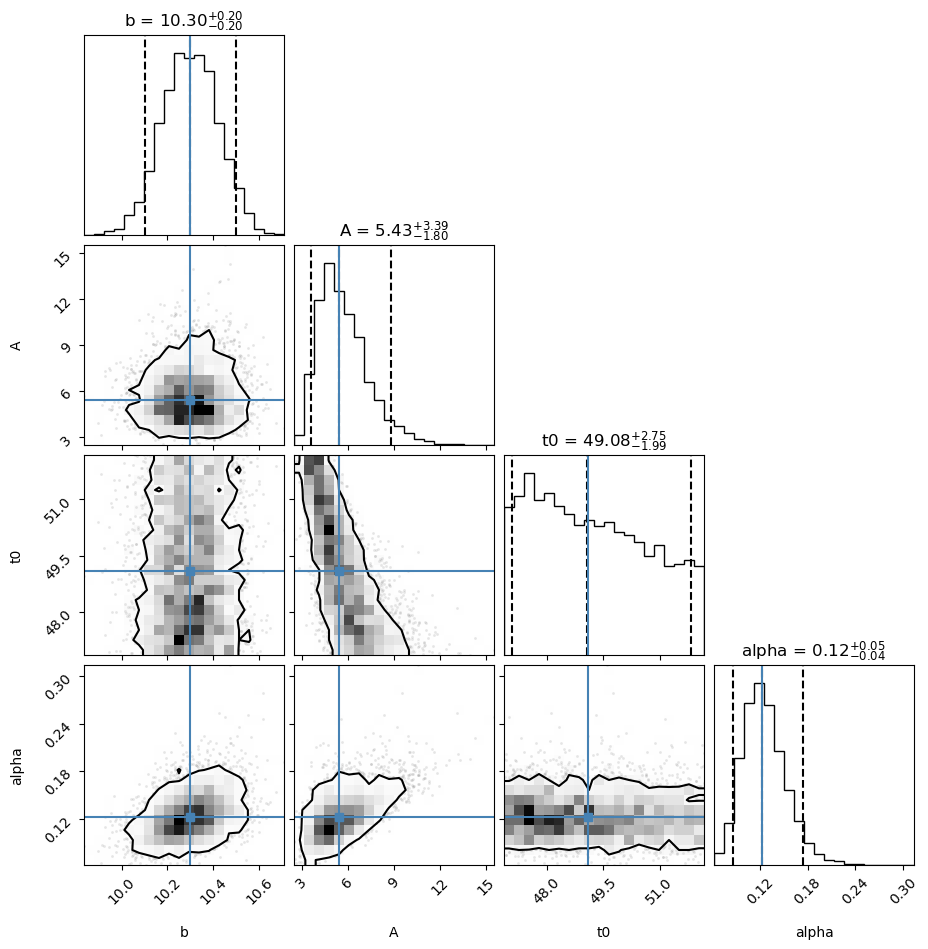

In [54]:
plot_sampler = sampler.get_chain(discard=burn,thin=thin,flat=True)
fig = corner.corner(plot_sampler, levels=[0.9],labels=labels,
                    truths=medians,show_titles=True,quantiles=[0.05,0.5,0.95])

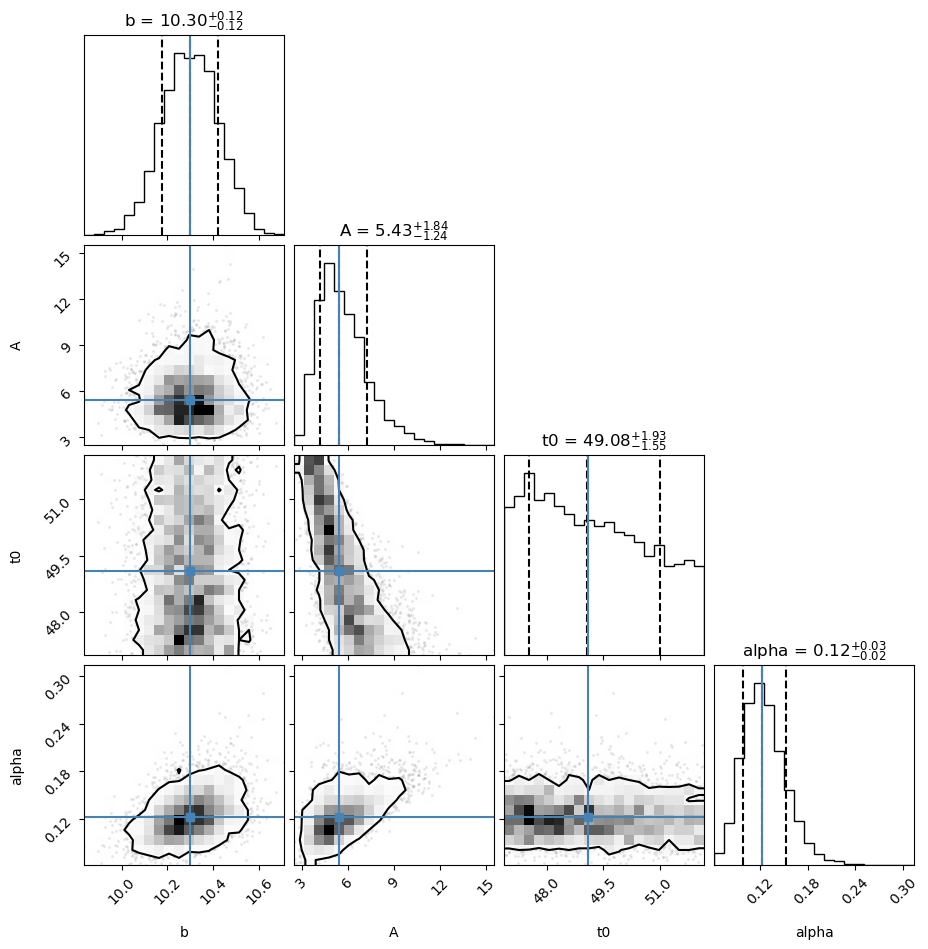

In [57]:
plot_sampler = sampler.get_chain(discard=burn,thin=thin,flat=True)
fig = corner.corner(plot_sampler, levels=[0.9],labels=labels,
                    truths=medians,show_titles=True,quantiles=[0.16,0.5,0.84])

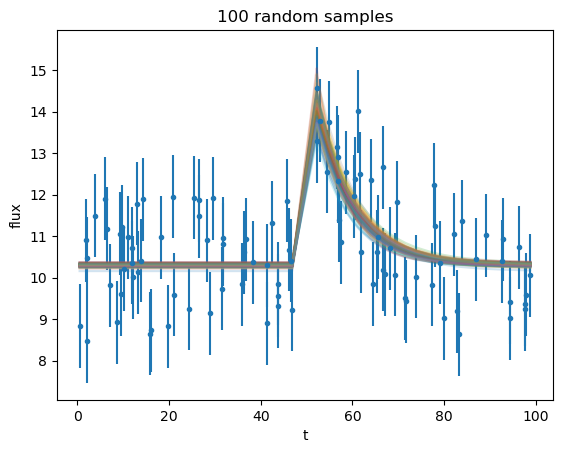

In [55]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.')
rand_step = (np.random.rand(100)*len(sampler_plot)).astype(int)  #random steps
for i in rand_step:  #parameters: median of the parameter at the random step
    plt.plot(data[:,0],model(np.median(sampler_plot[i],0),data[:,0]),'-',alpha =0.2)
plt.xlabel('t')
plt.ylabel('flux')
plt.title('100 random samples')
plt.show()

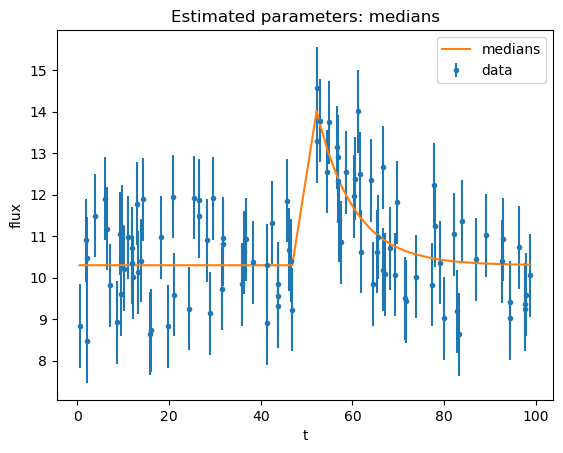

In [56]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.',label='data')
plt.plot(data[:,0],model(medians,data[:,0]),'-',label='medians')
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.title('Estimated parameters: medians')
plt.show()